In [58]:
import numpy as np  
import pandas as pd 
import scanpy as sc 
# 设置日志的详细程度，0表示只显示错误，1显示警告，2显示信息，3显示提示
sc.settings.verbosity = 3
# 打印Scanpy包的信息
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'output/data-GSM-matrix.h5ad'

# 从指定的目录读取10x Genomics格式的数据文件
# 参数./filtered_gene_bc_matrices/hg19/是存放MTX文件的目录
# 参数var_names='gene_symbols'表示使用基因符号作为变量名
# 参数cache=True表示缓存文件，以便以后更快地读取
adata = sc.read_10x_mtx(
    './data/GSM/',  
    var_names='gene_symbols',  
    cache=True)  

... reading from cache file cache\data-GSM-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


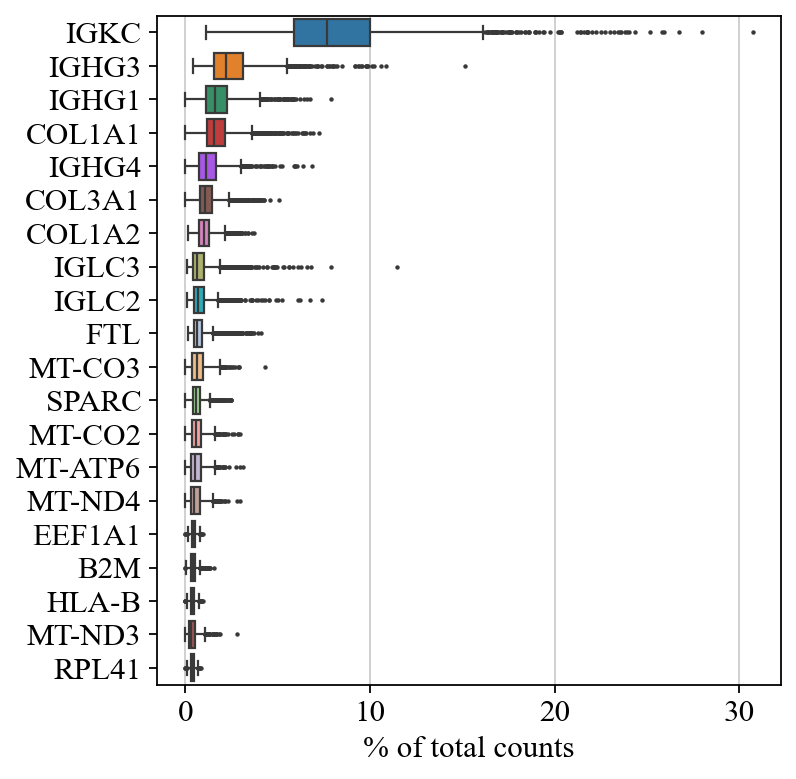

In [59]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [60]:
# 过滤低质量细胞样本
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2 cells that have less than 200 genes expressed
filtered out 14707 genes that are detected in less than 3 cells


In [61]:
# 将线粒体基因标记为 'mt'
# 创建一个新的列 'mt'，用于标记线粒体基因。
# 如果基因名以 "MT-" 开头，则认为它是线粒体基因，标记为 True；否则标记为 False。
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# 计算质量控制（QC）指标
sc.pp.calculate_qc_metrics(
    adata,                          # 输入的 AnnData 对象
    qc_vars=["mt"],                 # 指定需要计算的 QC 指标变量，这里计算线粒体基因（mt）相关的指标
    percent_top=None,               # 不计算最高表达基因的百分比（默认值）
    log1p=False,                    # 不对结果取 log1p 变换（默认值）
    inplace=True                    # 将计算结果直接存储在 adata 对象中
)

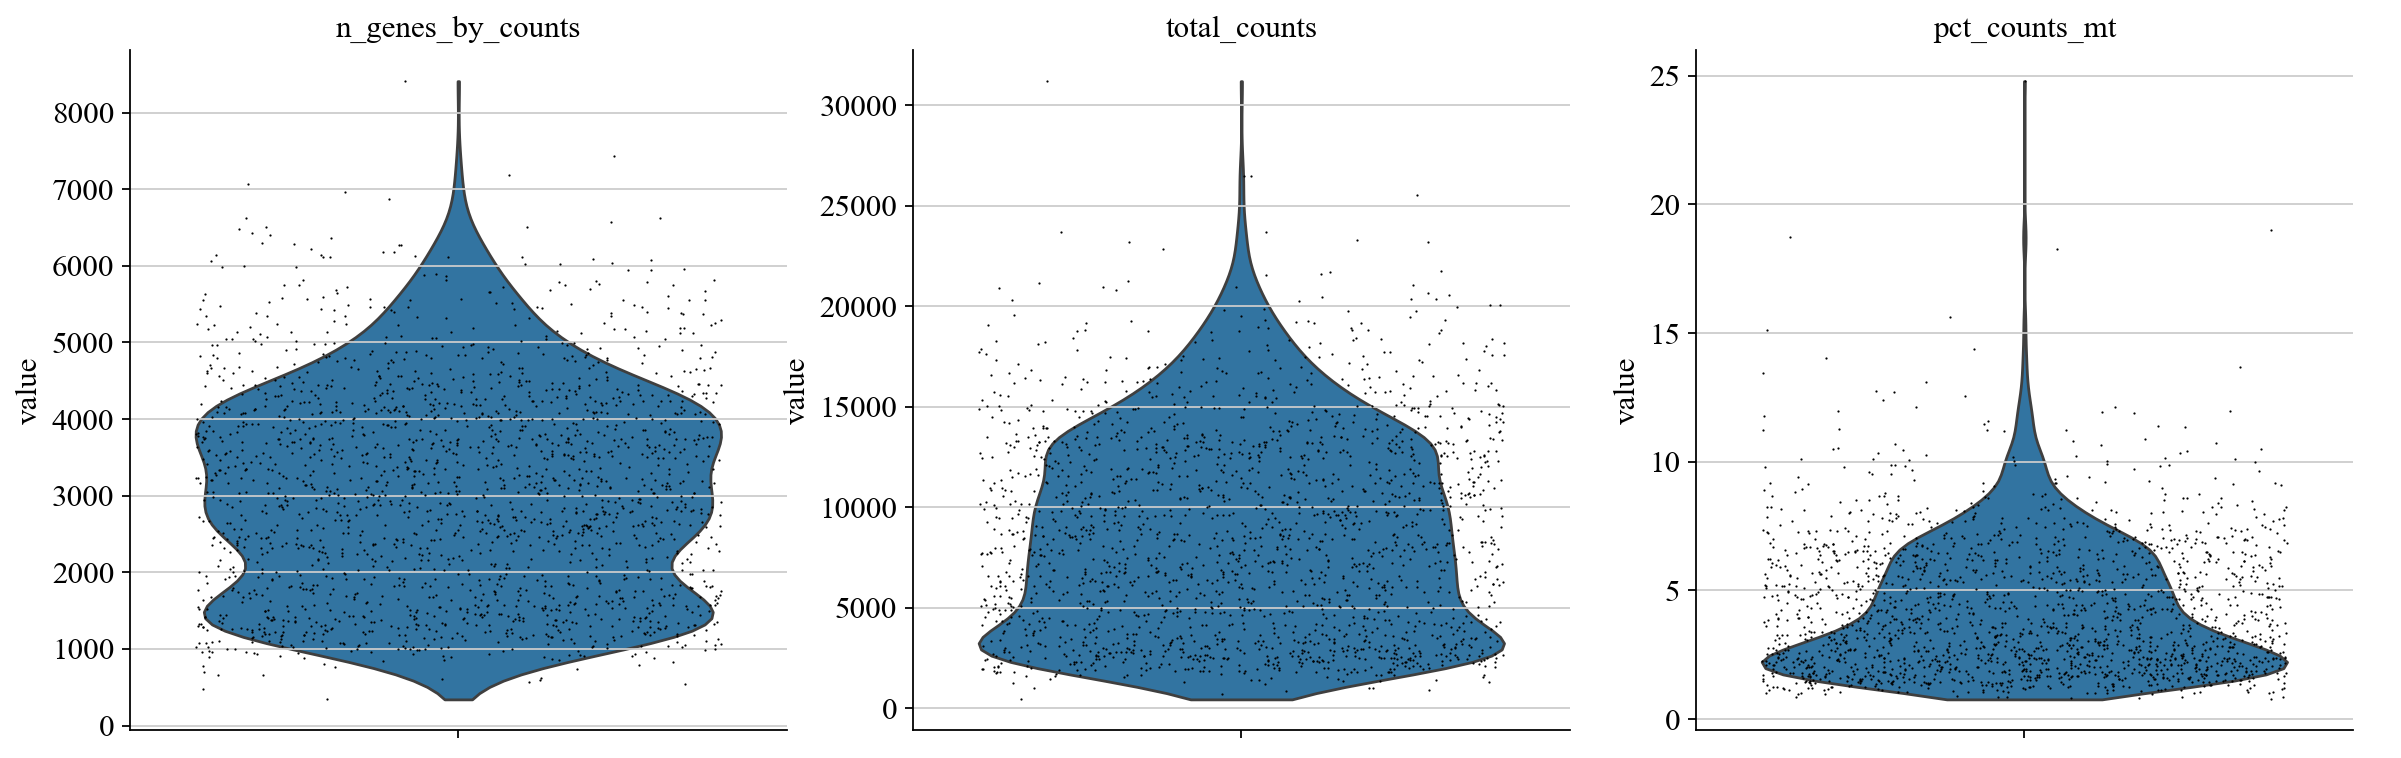

In [62]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

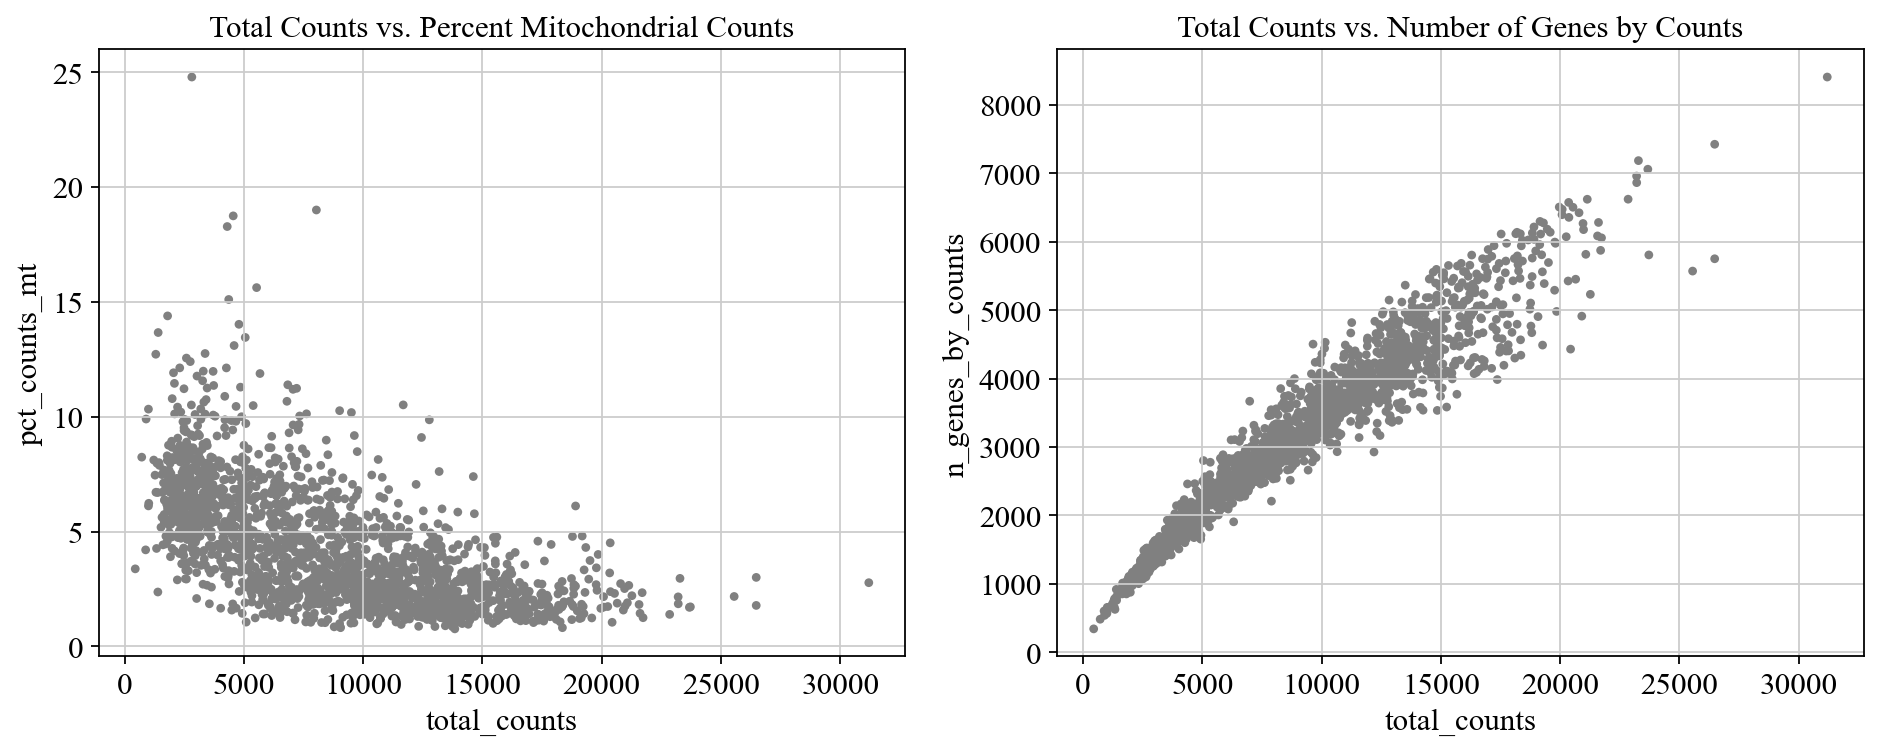

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
# 在第一个子图中绘制总表达量与线粒体基因比例的关系
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=axes[0], show=False)  
axes[0].set_title("Total Counts vs. Percent Mitochondrial Counts")  
# 在第二个子图中绘制总表达量与检测到的基因数的关系
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axes[1], show=False)  
axes[1].set_title("Total Counts vs. Number of Genes by Counts") 
plt.tight_layout()
plt.show()

In [64]:
# 筛选检测到的基因数小于2500的细胞
# adata.obs.n_genes_by_counts 是一个包含每个细胞检测到的基因数的列
# 这里我们保留基因数小于2500的细胞，排除基因数过多的异常细胞
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# 筛选线粒体基因比例小于5%的细胞
# adata.obs.pct_counts_mt 是一个包含每个细胞线粒体基因表达比例的列
# 这里我们保留线粒体基因比例小于5%的细胞，排除可能受损的细胞
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [65]:
# 对数据进行总和归一化，使每个细胞的总表达量（UMI数）标准化为目标值
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [66]:
# 做对数
sc.pp.log1p(adata)

In [67]:
# 寻找高变基因，指在不同细胞中表达水平差异较大的基因，这些基因通常在后续分析中更具生物学意义
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


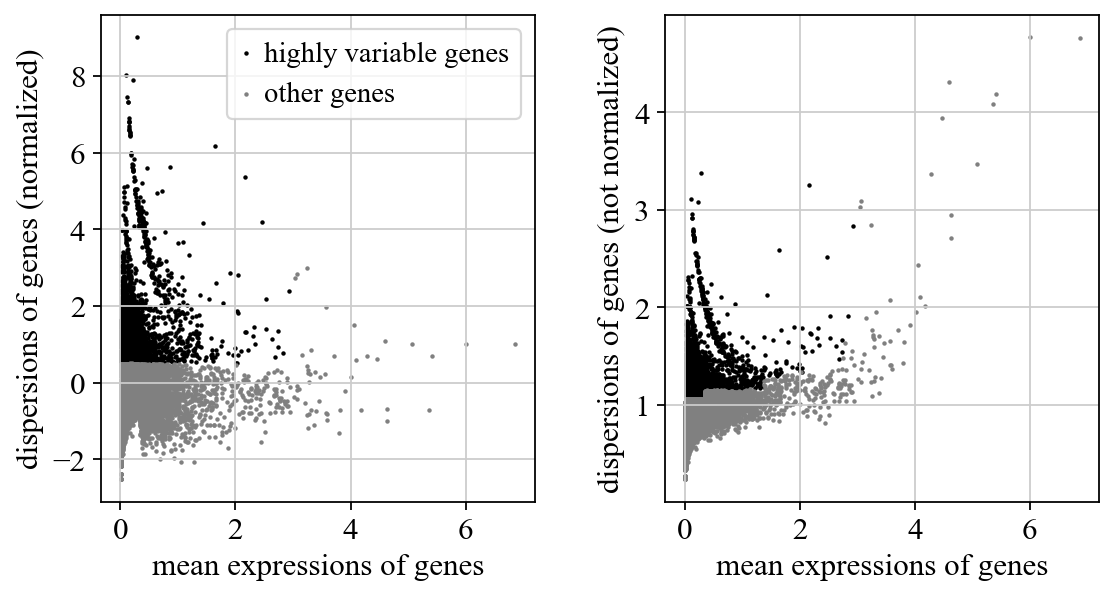

In [68]:
sc.pl.highly_variable_genes(adata)

# 将 AnnData 对象的属性设置为标准化和对数化的原始基因表达，以便以后用于基因表达的差异检测和可视化。这只是冻结 AnnData 对象的状态。

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


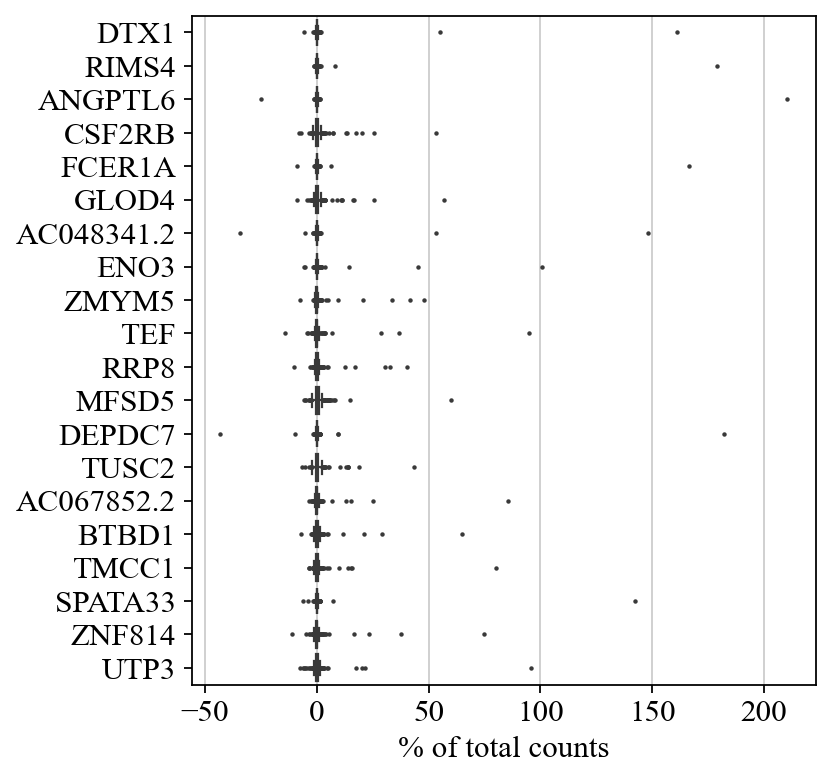

In [69]:
# 仅保留高变基因
adata = adata[:, adata.var.highly_variable]
# adata.var.highly_variable 是一个布尔数组，表示每个基因是否为高变基因。

# 使用线性回归去除总表达量和线粒体基因比例的影响
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
# 1. total_counts：每个细胞的总表达量（UMI数）。
# 2. pct_counts_mt：每个细胞的线粒体基因表达比例。

# 对数据进行标准化（Z-score标准化），并将值限制在 [-10, 10] 范围内
sc.pp.scale(adata, max_value=10)
# max_value=10 参数限制了标准化后的值范围，避免极端值对后续分析（如降维）产生过大影响。
# 标准化后的数据更适合用于主成分分析 PCA
sc.pl.highest_expr_genes(adata, n_top=20, )

# PCA

In [70]:
# 对数据进行PCA降维
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


KeyError: 'Could not find key CST3 in .var_names or .obs.columns.'

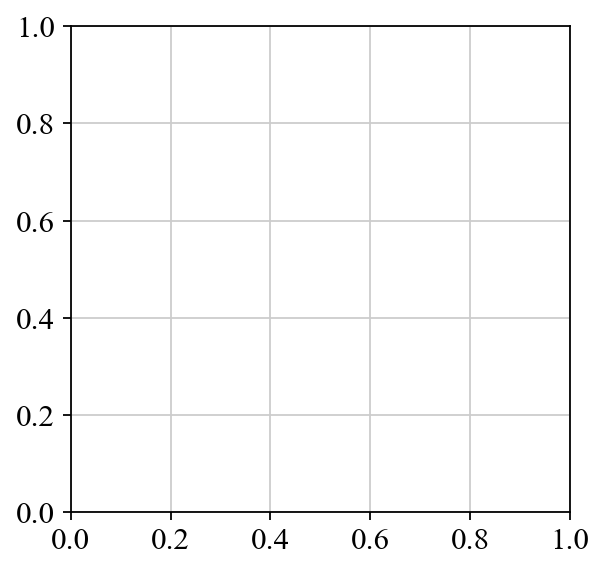

In [72]:
sc.pl.pca(adata, color="CST3")

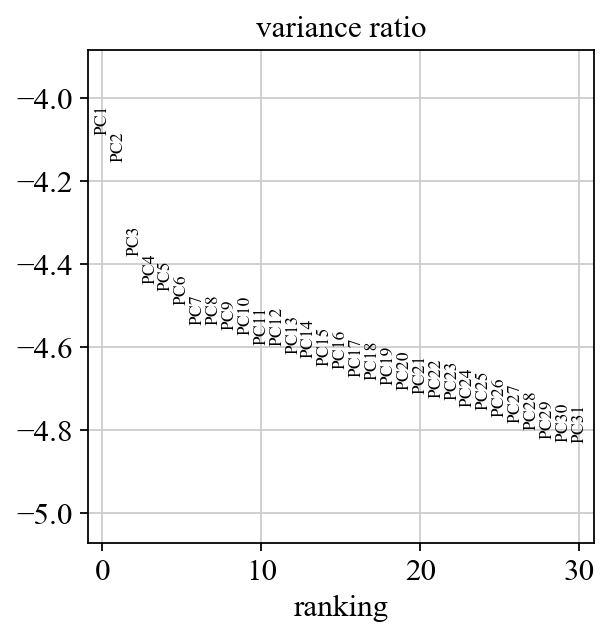

In [73]:
sc.pl.pca_variance_ratio(adata, log=True)

In [74]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 210 × 3725
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [75]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [76]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


In [77]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

KeyError: 'Could not find key CST3 in .var_names or .obs.columns.'

<Figure size 1159.2x320 with 0 Axes>